# Calculate Free Energy 

In [1]:
from ase.build import bulk
import numpy as np
from atomistics.workflows import optimize_positions_and_volume, LangevinWorkflow, PhonopyWorkflow, QuasiHarmonicWorkflow
from atomistics.calculators import evaluate_with_lammps_library, evaluate_with_lammps, get_potential_by_name, calc_molecular_dynamics_langevin_with_lammps, evaluate_with_hessian
from pylammpsmpi import LammpsASELibrary
from phonopy.units import VaspToTHz
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas

In [2]:
steps = 3000

In [3]:
structure_bulk = bulk("Al", cubic=True)

In [4]:
df_pot_selected = pandas.DataFrame({
    "Config": [[
        "pair_style morse/smooth/linear 9.0",
        "pair_coeff * * 0.5 1.8 2.95"
    ]],
    "Filename": [[]],
    "Model": ["Morse"],
    "Name": ["Morse"],
    "Species": [["Al"]],
})

In [5]:
task_dict = optimize_positions_and_volume(structure=structure_bulk)
result_dict = evaluate_with_lammps(
    task_dict=task_dict,
    potential_dataframe=df_pot_selected,
)
structure_opt = result_dict["structure_with_optimized_positions_and_volume"]

/Users/janssen/projects/pylammpsmpi/pylammpsmpi/wrapper/ase.py:165: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(


In [6]:
structure = structure_opt.repeat([3, 3, 3])

## Harmonic Approximation

In [7]:
workflow_fix = PhonopyWorkflow(
    structure=structure,
    interaction_range=10,
    factor=VaspToTHz,
    displacement=0.01,
    dos_mesh=20,
    primitive_matrix=None,
    number_of_snapshots=None,
)
structure_dict = workflow_fix.generate_structures()
result_dict = evaluate_with_lammps(
    task_dict=structure_dict,
    potential_dataframe=df_pot_selected,
)
workflow_fix.analyse_structures(output_dict=result_dict)
term_base_dict = workflow_fix.get_thermal_properties(
    t_min=1,
    t_max=1500,
    t_step=50,
    temperatures=None,
    cutoff_frequency=None,
    pretend_real=False,
    band_indices=None,
    is_projection=False,
)

## Quasi-Harmonic Approximation

In [8]:
workflow_qh = QuasiHarmonicWorkflow(
    structure=structure_opt,
    num_points=11,
    vol_range=0.05,
    interaction_range=10,
    factor=VaspToTHz,
    displacement=0.01,
    dos_mesh=20,
    primitive_matrix=None,
    number_of_snapshots=None,
)
structure_dict = workflow_qh.generate_structures()
result_dict = evaluate_with_lammps(
    task_dict=structure_dict,
    potential_dataframe=df_pot_selected,
)
workflow_qh.analyse_structures(output_dict=result_dict)
term_qh_dict = workflow_qh.get_thermal_properties(
    t_min=1,
    t_max=1500,
    t_step=250,
    temperatures=None,
    cutoff_frequency=None,
    pretend_real=False,
    band_indices=None,
    is_projection=False,
)

In [9]:
lattice_constant_lst = np.array(term_qh_dict['volumes']) ** (1/3)
temperature_lst = term_qh_dict['temperatures']

## Thermo Dynamic Integration

In [10]:
steps_lst = list(range(steps))

In [11]:
lambda_lst = np.linspace(0.0, 1.0, 5)

In [12]:
free_energy_lst, eng_lambda_dependence_lst = [], []
for lattice_constant, temperature in zip(lattice_constant_lst, temperature_lst):
    structure = bulk("Al", a=lattice_constant, cubic=True).repeat([3, 3, 3])
    equilibrium_lammps = evaluate_with_lammps(task_dict={"calc_energy": structure}, potential_dataframe=df_pot_selected)['energy']
    equilibrium_hessian = evaluate_with_hessian(task_dict={"calc_energy": structure}, structure_equilibrium=structure, force_constants=workflow_fix.get_hesse_matrix(), bulk_modulus=0, shear_modulus=0,)['energy']
    workflow_fix = PhonopyWorkflow(
        structure=structure,
        interaction_range=10,
        factor=VaspToTHz,
        displacement=0.01,
        dos_mesh=20,
        primitive_matrix=None,
        number_of_snapshots=None,
    )
    structure_dict = workflow_fix.generate_structures()
    result_dict = evaluate_with_lammps(
        task_dict=structure_dict,
        potential_dataframe=df_pot_selected,
    )
    workflow_fix.analyse_structures(output_dict=result_dict)
    term_fix_dict = workflow_fix.get_thermal_properties(
        t_min=1,
        t_max=1500,
        t_step=250,
        temperatures=None,
        cutoff_frequency=None,
        pretend_real=False,
        band_indices=None,
        is_projection=False,
    )
    energy_pot_all_lst, energy_mean_lst, energy_kin_all_lst = [], [], []
    for lambda_parameter in lambda_lst: 
        thermo_eng_pot_lst, thermo_eng_kin_lst = [], []
        workflow_md_thermo = LangevinWorkflow(
            structure=structure,
            temperature=temperature,
            overheat_fraction=2.0,
            damping_timescale=100.0,
            time_step=1,
        )
        lmp = LammpsASELibrary(
            working_directory=None,
            cores=1,
            comm=None,
            logger=None,
            log_file=None,
            library=None,
            diable_log_file=True,
        )
        for i in tqdm(steps_lst):
            task_dict = workflow_md_thermo.generate_structures()
            hessian_dict = evaluate_with_hessian(
                task_dict=task_dict,
                structure_equilibrium=structure,
                force_constants=workflow_fix.get_hesse_matrix(),
                bulk_modulus=0,
                shear_modulus=0,
            )
            lammps_dict = evaluate_with_lammps_library(
                task_dict=task_dict,
                potential_dataframe=df_pot_selected,
                lmp=lmp,
            )
            result_dict = {
                "forces": {0: lambda_parameter * hessian_dict["forces"][0] + (1-lambda_parameter) * lammps_dict["forces"][0]},
                "energy": {0: lambda_parameter * hessian_dict["energy"][0] + (1-lambda_parameter) * (lammps_dict["energy"][0] - equilibrium_lammps)},
            }
            eng_pot, eng_kin = workflow_md_thermo.analyse_structures(output_dict=result_dict)
            thermo_eng_pot_lst.append(eng_pot)
            thermo_eng_kin_lst.append(eng_kin)
        lmp.close()
        thermo_energy = np.array(thermo_eng_pot_lst) + np.array(thermo_eng_kin_lst)
        energy_mean_lst.append(np.mean(thermo_energy[1000:]))
        energy_pot_all_lst.append(thermo_eng_pot_lst)
        energy_kin_all_lst.append(thermo_eng_kin_lst)
    eng_lambda_dependence_lst.append(np.array(energy_mean_lst) / len(structure) * 1000)
    fit = np.poly1d(np.polyfit(lambda_lst, np.array(energy_mean_lst) / len(structure) * 1000, 3))
    integral = np.polyint(fit)
    free_energy_lst.append(integral(1.0) - integral(0.0))

100%|██████████████████████████████████████| 3000/3000 [00:06<00:00, 476.57it/s]


## Summary

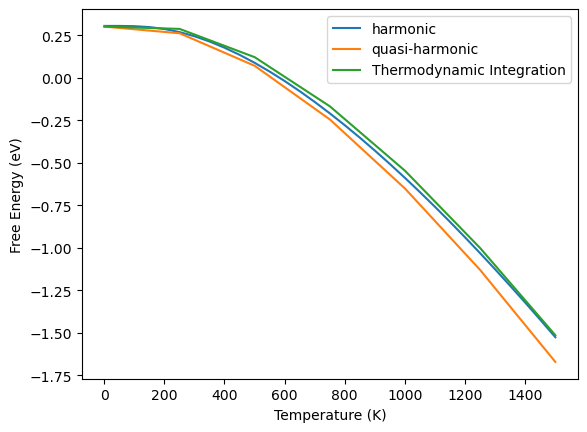

In [13]:
plt.plot(term_base_dict['temperatures'], term_base_dict['free_energy']/ len(structure) * len(structure_bulk), label="Harmonic")
plt.plot(term_qh_dict['temperatures'], term_qh_dict['free_energy'], label="Quasi-Harmonic")
plt.plot(term_qh_dict['temperatures'], term_qh_dict['free_energy'] + np.array(free_energy_lst) / 1000, label="Thermodynamic Integration")
plt.xlabel("Temperature (K)")
plt.ylabel("Free Energy (eV)")
plt.legend()